<a href="https://colab.research.google.com/github/siddarthpaim/AzureHack/blob/master/ModellingVentillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Import List of Libraries needed
!pip3 install -U lazypredict


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 2.5 MB/s 
     |████████████████████████████████| 14.5 MB 5.6 MB/s 
     |████████████████████████████████| 25.9 MB 13.6 MB/s 
     |████████████████████████████████| 6.8 MB 42.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.5 MB/s 
     |████████████████████████████████| 269 kB 40.1 MB/s 
     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 127.6 MB 20 kB/s 
     |████████████████████████████████| 10.1 MB 40.4 MB/s 
     |████████████████████████████████| 302 kB 49.8 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=23430bcf572e019ced84c7c15e29daaf51abf83894fe4e06f82667cf9258492a
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: nump

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np
import time
import lightgbm as lgb
import missingno as msno
from sklearn.model_selection import GroupKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [19]:
path = '/content/drive/MyDrive/Data Mining/Group-Project/Ventillator/ventilator-pressure-prediction'

In [20]:
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))
sub = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [ ]:
train.nunique().to_frame()

,0
id,6036000
breath_id,75450
R,3
C,3
time_step,3767571
u_in,4020300
u_out,2
pressure,950


## MAPE 
The mean absolute percentage error, also known as mean absolute percentage deviation, is a measure of prediction accuracy of a forecasting method in statistics

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

**Data Processing**


In [5]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [6]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [7]:
Dataset = pd.DataFrame({'Rows':[train.shape[0],test.shape[0]], 'Columns':[train.shape[1], test.shape[1]]},
                  index = ['Train Dataset', 'Test Dataset'])
Dataset

,Rows,Columns
Train Dataset,6036000,8
Test Dataset,4024000,7


**Data** **Structure Type**

In [10]:
train.info()
print('----------------')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024000 entries, 0 to 4023999
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
dtypes: float64(2), int64(5)
memory usage: 214.9 MB


**Analysis for Missing Values**

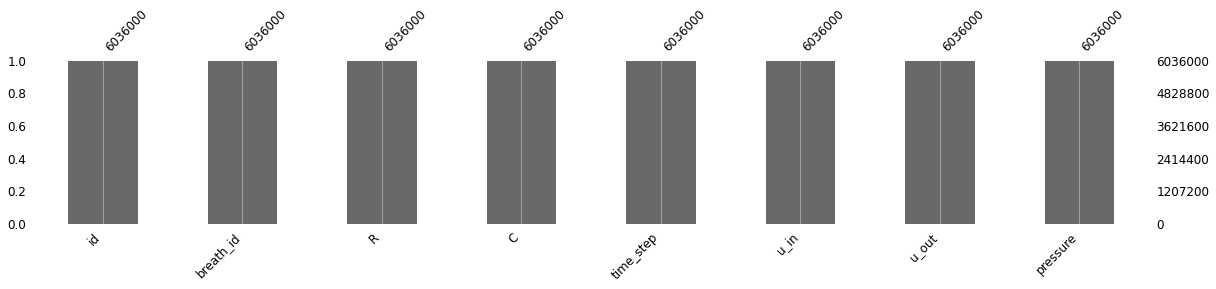

In [12]:
msno.bar(train, figsize = (20,3), fontsize = 12)
plt.grid();

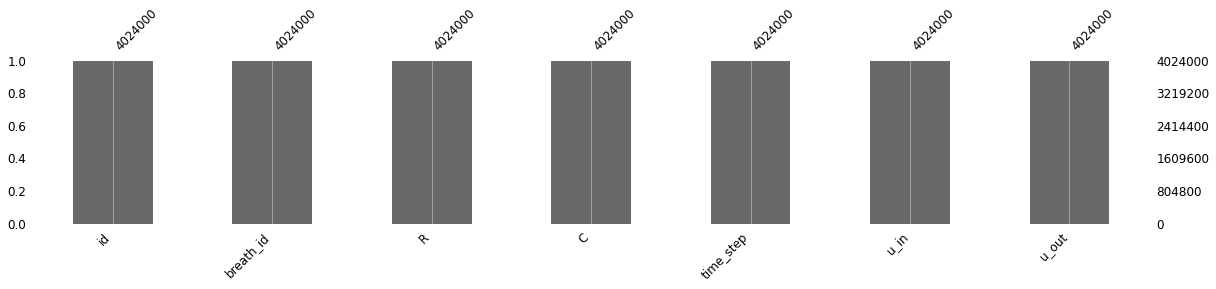

In [13]:
msno.bar(test, figsize = (20,3), fontsize = 12)
plt.grid();

In [14]:
dupstr = train.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))

train[dupstr]

Total no of duplicate values in Training Dataset = 0


,id,breath_id,R,C,time_step,u_in,u_out,pressure


In [15]:
dupstr = test.duplicated()
print('Total no of duplicate values in Test Dataset = %d' % (dupstr.sum()))

test[dupstr]

Total no of duplicate values in Test Dataset = 0


,id,breath_id,R,C,time_step,u_in,u_out


**Correlation Matrix**

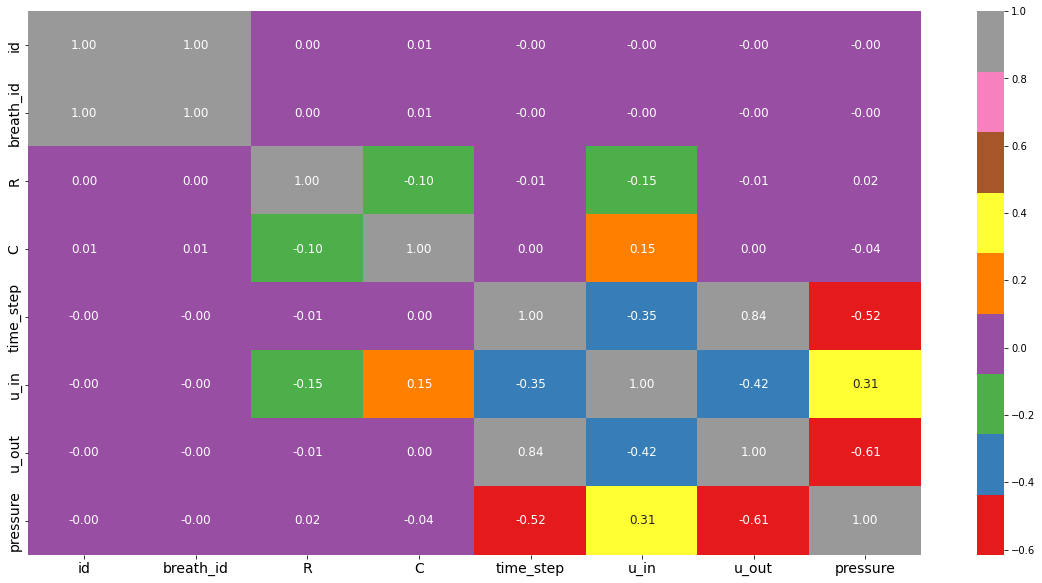

In [11]:
plt.figure(figsize = (20,10))
sns.heatmap(train.corr(), annot = True, fmt = '3.2f' , annot_kws={'size' : 12}, cmap="Set1")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
train.groupby("breath_id")["time_step"].count().unique().item()

80

In [ ]:
test.groupby("breath_id")["time_step"].count().unique().item()   

80

In [ ]:
train.time_step.max()

2.9372379779815674

In [ ]:
train.query('u_out == 0').time_step.max()

0.999798059463501

In [ ]:
breath_one = train.query('breath_id == 1').reset_index(drop = True)
breath_one
breath_two = train.query('breath_id == 2').reset_index(drop = True)
breath_two

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,81,2,20,20,0.000000,12.184338,0,6.048398
1,82,2,20,20,0.033998,13.980205,0,7.524743
2,83,2,20,20,0.068151,12.574163,0,9.282297
3,84,2,20,20,0.102062,11.730537,0,10.336829
4,85,2,20,20,0.135917,12.124229,0,9.844714
...,...,...,...,...,...,...,...,...
75,156,2,20,20,2.554363,4.977307,1,5.064168
76,157,2,20,20,2.588413,4.980860,1,5.204772
77,158,2,20,20,2.622476,4.983857,1,4.993866
78,159,2,20,20,2.656502,4.986382,1,5.064168


In [ ]:
breath_one.nunique().to_frame()

,0
id,80
breath_id,1
R,1
C,1
time_step,80
u_in,64
u_out,2
pressure,59


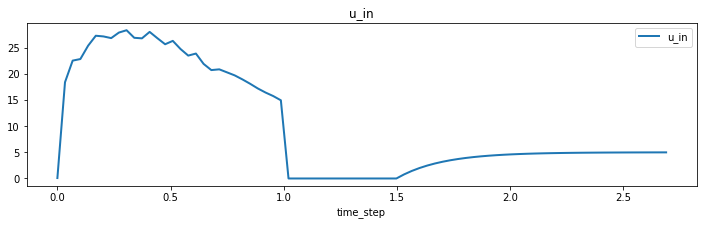

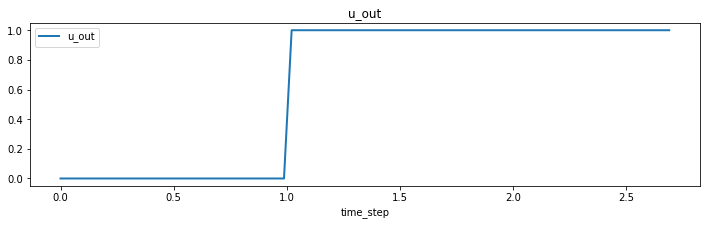

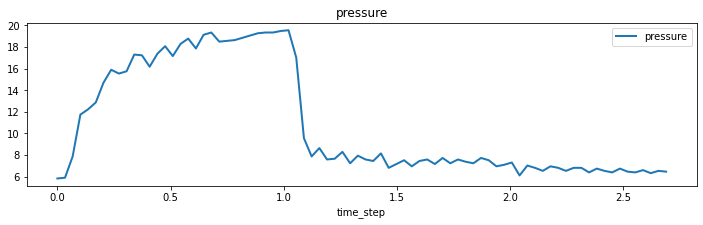

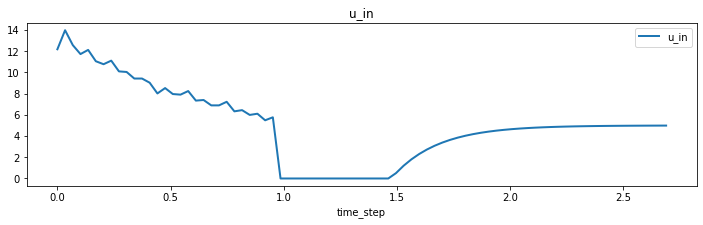

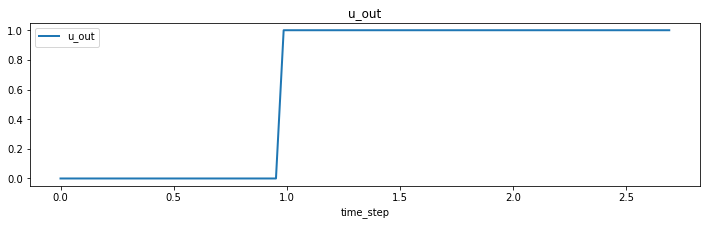

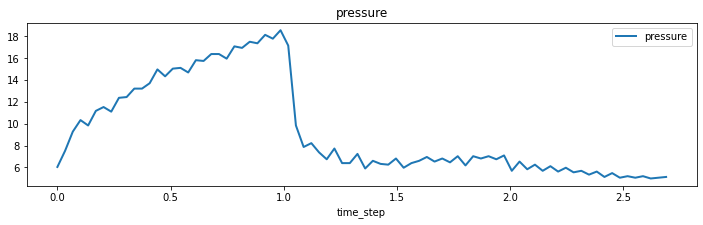

In [ ]:
breath_one.plot(x="time_step", y="u_in", kind='line',figsize=(12,3), lw=2, title="u_in");
breath_one.plot(x="time_step", y="u_out", kind='line',figsize=(12,3), lw=2, title="u_out");
breath_one.plot(x="time_step", y="pressure", kind='line',figsize=(12,3), lw=2, title="pressure");
breath_two.plot(x="time_step", y="u_in", kind='line',figsize=(12,3), lw=2, title="u_in");
breath_two.plot(x="time_step", y="u_out", kind='line',figsize=(12,3), lw=2, title="u_out");
breath_two.plot(x="time_step", y="pressure", kind='line',figsize=(12,3), lw=2, title="pressure");

In [ ]:
train.pressure.max()

64.8209917386395

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


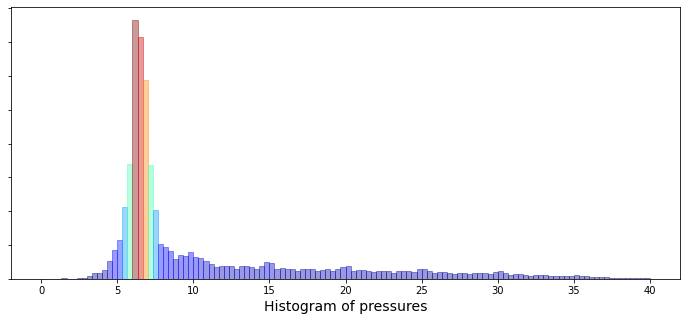

In [ ]:
plt.figure(figsize = (12,5))
ax = sns.distplot(train['pressure'], 
             bins=120, 
             kde_kws={"clip":(0,40)}, 
             hist_kws={"range":(0,40)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of pressures", size=14)
ax.set(yticklabels=[])
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


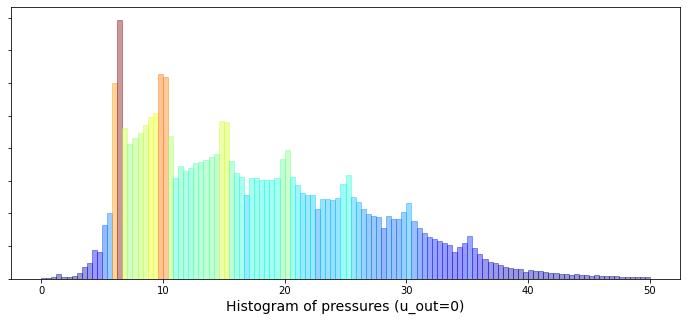

In [ ]:
u_out_is_zero = train.query("u_out == 0").reset_index(drop = True)
plt.figure(figsize = (12,5))
ax = sns.distplot(u_out_is_zero['pressure'], 
             bins=120, 
             kde_kws={"clip":(0,50)}, 
             hist_kws={"range":(0,50)},
             color='darkcyan', 
             kde=False);
values = np.array([rec.get_height() for rec in ax.patches])
norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.jet(norm(values))
for rec, col in zip(ax.patches, colors):
    rec.set_color(col)
plt.xlabel("Histogram of pressures (u_out=0)", size=14)
ax.set(yticklabels=[])
plt.show();

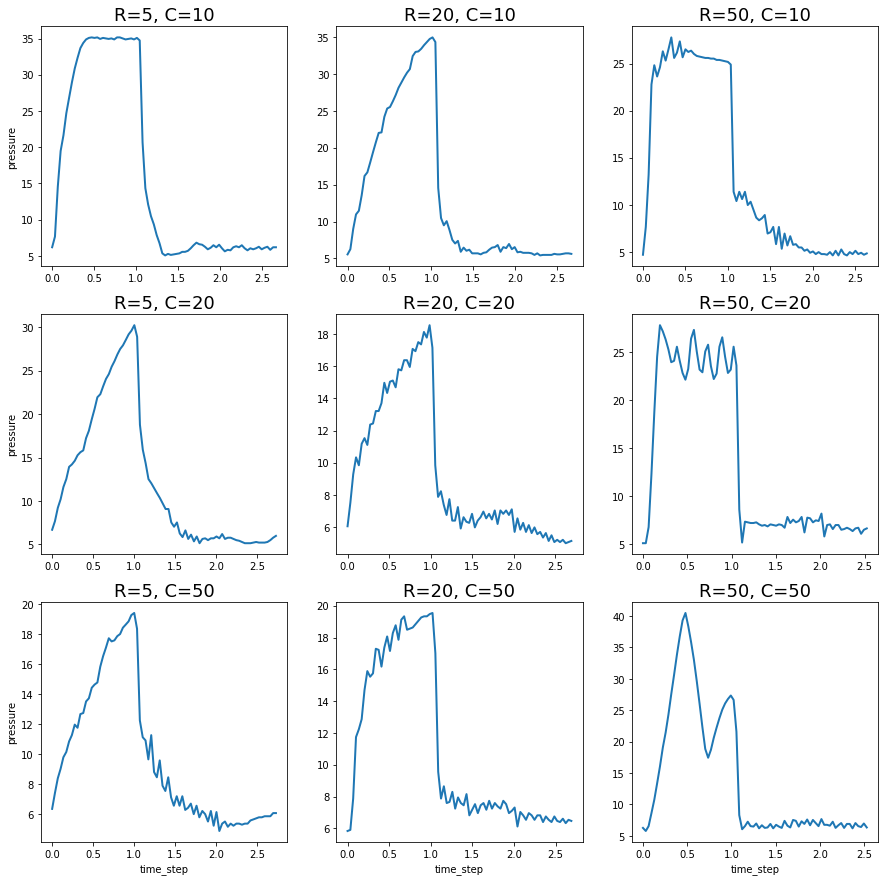

In [ ]:
breath_2 = train.query('breath_id == 2').reset_index(drop = True)
breath_3 = train.query('breath_id == 3').reset_index(drop = True)
breath_4 = train.query('breath_id == 4').reset_index(drop = True)
breath_5 = train.query('breath_id == 5').reset_index(drop = True)
breath_17 = train.query('breath_id == 17').reset_index(drop = True)
breath_18 = train.query('breath_id == 18').reset_index(drop = True)
breath_21 = train.query('breath_id == 21').reset_index(drop = True)
breath_39 = train.query('breath_id == 39').reset_index(drop = True)

fig, axes = plt.subplots(3,3,figsize=(15,15))
sns.lineplot(data=breath_39, x="time_step", y="pressure", lw=2, ax=axes[0,0])
axes[0,0].set_title ("R=5, C=10", fontsize=18)
axes[0,0].set(xlabel='')
#axes[0,0].set(ylim=(0, None))
sns.lineplot(data=breath_21, x="time_step", y="pressure",  lw=2, ax=axes[0,1])
axes[0,1].set_title ("R=20, C=10", fontsize=18)
axes[0,1].set(xlabel='')
axes[0,1].set(ylabel='')
#axes[0,1].set(ylim=(0, None))
sns.lineplot(data=breath_18, x="time_step", y="pressure",  lw=2,ax=axes[0,2])
axes[0,2].set_title ("R=50, C=10", fontsize=18)
axes[0,2].set(xlabel='')
axes[0,2].set(ylabel='')
#axes[0,2].set(ylim=(0, None))
sns.lineplot(data=breath_17, x="time_step", y="pressure",  lw=2,ax=axes[1,0])
axes[1,0].set_title ("R=5, C=20", fontsize=18)
axes[1,0].set(xlabel='')
#axes[1,0].set(ylim=(0, None))
sns.lineplot(data=breath_2, x="time_step", y="pressure",  lw=2,ax=axes[1,1])
axes[1,1].set_title ("R=20, C=20", fontsize=18)
axes[1,1].set(xlabel='')
axes[1,1].set(ylabel='')
#axes[1,1].set(ylim=(0, None))
sns.lineplot(data=breath_3, x="time_step", y="pressure",  lw=2,ax=axes[1,2])
axes[1,2].set_title ("R=50, C=20", fontsize=18)
axes[1,2].set(xlabel='')
axes[1,2].set(ylabel='')
#axes[1,2].set(ylim=(0, None))
sns.lineplot(data=breath_5, x="time_step", y="pressure",  lw=2,ax=axes[2,0])
axes[2,0].set_title ("R=5, C=50", fontsize=18)
#axes[2,0].set(ylim=(0, None))
sns.lineplot(data=breath_one, x="time_step", y="pressure",  lw=2,ax=axes[2,1])
axes[2,1].set_title ("R=20, C=50", fontsize=18)
axes[2,1].set(ylabel='')
#axes[2,1].set(ylim=(0, None))
sns.lineplot(data=breath_4, x="time_step", y="pressure",  lw=2,ax=axes[2,2])
axes[2,2].set_title ("R=50, C=50", fontsize=18)
axes[2,2].set(ylabel='')
#axes[2,2].set(ylim=(0, None))

plt.show();

In [ ]:
X_train = train.drop(['pressure'], axis=1)
y_train = train['pressure']
from sklearn.experimental import LinearRegression
regressor  =  LinearRegression(max_iter=100,
     loss="least_absolute_deviation",early_stopping=False)
regressor.fit(X_train, y_train)
sub["pressure"] = regressor.predict(test)
sub.to_csv('submission.csv',index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py:1316: FutureWarning: The loss 'least_absolute_deviation' was deprecated in v1.0  and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  FutureWarning,


In [ ]:
sub.head()

,id,pressure
0,1,6.227974
1,2,6.126613
2,3,7.126516
3,4,8.517307
4,5,10.820565


In [ ]:
sub.describe()

,id,pressure
count,4.024000e+06,4.024000e+06
mean,2.012000e+06,1.080903e+01
std,1.161629e+06,6.438207e+00
min,1.000000e+00,3.596866e+00
25%,1.006001e+06,6.380608e+00
50%,2.012000e+06,6.899732e+00
75%,3.018000e+06,1.525041e+01
max,4.024000e+06,3.446300e+01


**Model Development**

Dropping Irrelevant Values

In [23]:
X = train.drop(['id','breath_id','pressure'], axis=1)
y = train['pressure']

Train and Test Split

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=.2,random_state =1)

**Linear Regression**

In [25]:
lr = LinearRegression()

In [10]:
from IPython.display import clear_output
!pip3 install -U lazypredict

clear_output()

In [11]:


from lazypredict import Supervised
from lazypredict.Supervised import LazyRegressor

In [14]:
!pip3 install -U pandas==1.2.3 #Upgrading pandas
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import lazypredict
from lazypredict import Supervised
from lazypredict.Supervised import LazyRegressor
clear_output()

In [24]:
model = lr.fit(X_train, y_train)

NameError: ignored

In [39]:
print("R-Square : " ,model.score(X_valid,y_valid))


R-Square :  0.3823315623616593


In [26]:
num_models = 28
reg_idx = [i for i in range(num_models)]
noregs_idx = [8,8,8,8,12,12,12,19,19,19,20,20,21,24] # Removing 14 models from 42 models. Removed models require lot of ram and getting error too 
regs_name =[]
regs = []
for i in range(42):
    regs_name.append(lazypredict.Supervised.REGRESSORS[i][0])
    regs.append(lazypredict.Supervised.REGRESSORS[i][1])

for i in noregs_idx:
    del regs_name[i]
    del regs[i]
print("ALL 28 AVAILABLE REGRESSION MODELS:")
for i in range(num_models):
    print(i+1 , regs_name[i])

ALL 28 AVAILABLE REGRESSION MODELS:
1 AdaBoostRegressor
2 BaggingRegressor
3 BayesianRidge
4 DecisionTreeRegressor
5 DummyRegressor
6 ElasticNet
7 ElasticNetCV
8 ExtraTreeRegressor
9 GradientBoostingRegressor
10 HistGradientBoostingRegressor
11 HuberRegressor
12 KNeighborsRegressor
13 Lasso
14 LassoCV
15 LassoLars
16 LassoLarsCV
17 LassoLarsIC
18 LinearRegression
19 LinearSVR
20 OrthogonalMatchingPursuitCV
21 RANSACRegressor
22 Ridge
23 RidgeCV
24 SGDRegressor
25 TransformedTargetRegressor
26 TweedieRegressor
27 XGBRegressor
28 LGBMRegressor


In [ ]:
from sklearn.metrics import mean_absolute_error
results = pd.DataFrame()
for i in range(0,num_models):
    print(i,regs_name[i])
    reg = LazyRegressor(verbose=0, 
                    ignore_warnings=False,
                    custom_metric= mean_absolute_error, #Creating custome metric for mae
                    regressors = [regs[i]])
    models, predictions = reg.fit(X_train, X_valid, y_train, y_valid)
    models.index = [regs_name[i]]
    results = results.append(models)
clear_output()

  0%|          | 0/1 [00:00<?, ?it/s]

0 AdaBoostRegressor


  0%|          | 0/1 [00:00<?, ?it/s]

1 BaggingRegressor


In [16]:
results = results.sort_values(by = "mean_absolute_error")
print(results)

NameError: ignored